# SEP 769- Deep Learning Project- Optimizing Energy Usage in Buildings Using IoT Data and Deep Learning Algorithms
> Hongqing Cao 400053625  
Sushant Shailesh Panchal 400614293  
Yanyi He 400651032  
Yash Parab 400611922

## Introduction
This project aims to develop a deep learning-based system to optimize energy usage in buildings using data from IoT sensors. The goal is to reduce energy consumption and costs while maintaining occupant comfort and health. The project involves preprocessing data from IoT sensors, developing a deep learning model to optimize energy usage, and testing the model on new data to evaluate its effectiveness.

The dataset [**Individual Household Electric Power Consumption dataset**](https://archive.ics.uci.edu/dataset/235) is retrived from UCI Machine Learning Repository, which contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

### Objectives
- Load, clean, transform the dataset, and perform necessary feature engineering. 
- Design two deep neuro networks, Long Short-Term Memory (LSTM) and Sequence to Sequence enabled LSTM (Seq2Seq). 
- Compare both models over a subset of dataset, find the better performed one by evaluating loss (MSE). 
- Tune hypererameters, with learning rate, batch size, number of cells(ubits), dropout rate, and L2 regularization with another subset of dataset. 
- Train the tuned model with the major part of the dataset, and evaluate it by MSE and MAE metrics. 
- Forecast the next 24hr, and 7 Day power consumption with the model trained. 
- Visualize loss, metrics, and forecasting results. 


### Dataset
- **Source**: UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/235).
- **Information**: This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 

- **Columns**: 
    - `date: dd/mm/yyyy`
    - `time: hh:mm:ss`
    - `global_active_power: float` Total household active power usage in kilowatts (kW)
    - `reactive_power: float` Power not used for work, in KW
    - `voltage: float` Voltage across the circuit, in V
    - `global_intensity: float` Current drawn, in A
    - `sub_metering_1: float` Energy drawn for kitchen, in Wh
    - `sub_metering_2: float` Energy drawn for laundry, in Wh
    - `sub_metering_3: float` Energy drawn for water heater and AC, in Wh
-
- **Note**:  
`global_active_power * 1000 / 60- sub_metering_1- sub_metering_2- sub_metering_3`  
This variable (unused) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
-
- **Missing Data**: The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing (willed with `?`). 

### References
- Marino et al. (2016), *Building Energy Load Forecasting using Deep Neural Networks*. -
- Bonetto & Rossi (2017), *Machine Learning Approaches to Energy Consumption Forecasting in Households*. -
- Gasparin et al. (2019), *Deep Learning for Time Series Forecasting: The Electric Load Case*. 

### Essential Notes
- **Hardware**: The code in notebook in designed to best perform with CUDA GPUs, targeting RTX 4070. 
-
- **Environment**: Use `Python 3.11.7`, `NVIDIA-SMI 575.64.04`, `Driver Version: 577.00`, `CUDA Version: 12.9`. 

## 0. Environment Setup
### Libaries Imported
`numpy 2.1.3`  
`matplotlib 3.10.3`  
`pandas 2.3.1`  
`tensorflow 2.19.0`  
`scikit-learn 1.7.1`  
`keras 3.10.0`  
`tensorboard 2.19.0`  
`seaborn 0.13.2`  

In [122]:
### Libaries Imported
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from keras import Sequential, layers, Model, regularizers
from keras import backend as K
from keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import mixed_precision
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc

%load_ext tensorboard

np.random.seed(42)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### GPU Config
set `set_memory_growth`, `mixed_precision`

In [2]:
### GPU Config
# use set_memory_growth to aallocate VRAM

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# use mixed_precision to accelrate GPU speed

mixed_precision.set_global_policy('mixed_float16')

In [3]:
### Global Variables
DATA_DIR = "data"
RAW_DIR = DATA_DIR+"/raw"
TRAIN_DIR = DATA_DIR+"/train"
TEST_DIR = DATA_DIR+"/test"

MODEL_DIR = "model"

LOG_DIR = "log"
HPARAM_DIR = LOG_DIR+"/hparam"

### Utility Functions
- `delete_model(modelname, historyname)`
- `inspect_data(df, name)`
- `check_point(model_name, monitor = 'val_loss', save_best_only = True, hparam = False)`
- `early_stop(patience, monitor='val_loss',restore_best_weights=True)`
- `catch_hparam_result(results)`

In [106]:
### Utility functions

def delete_model(modelname, historyname):
    '''function for delete model, history and free vram'''
    global_vars = globals()
    if modelname in globals():
        del global_vars[modelname]
    if historyname in globals():
        del global_vars[historyname]
    gc.collect()
    K.clear_session()

def check_point(model_name, monitor = 'val_loss', save_best_only = True, hparam = False):
    
    model_dir = MODEL_DIR + '/' + model_name + '.keras'
    if hparam:
        model_dir = 'hparam/' + model_dir
    return ModelCheckpoint(
        model_dir,
        monitor=monitor,
        save_best_only=save_best_only
    )

def early_stop(patience, monitor='val_loss',restore_best_weights=True):
    return EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=restore_best_weights
    )

def inspect_data(df, name):
    '''print summary data of a given dataframe, with
    count
    mean
    std
    min
    25%
    50%
    75%
    max
    dtype
    '''
    print(f"\n{name} summary:")
    print(df.describe())
    print(df.isnull().sum())

# display hyperparameter tuning result
def catch_hparam_result(results):
    rows = []
    train_loss_tune = []
    val_loss_tune = []
    for hparams, train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap in results:
        row = {h.name: hparams[h] for h in hparams}
        row['best_epoch'] = best_epoch
        row['min_train_loss'] = min_train_loss
        row['min_val_loss'] = min_val_loss
        row['loss_gap'] = loss_gap
        rows.append(row)
        train_loss_tune.append(train_loss_history)
        val_loss_tune.append(val_loss_history)
        # print(len(train_loss_history))
    df = pd.DataFrame(rows).sort_values(by='min_val_loss')
    return df, train_loss_tune, val_loss_tune


### Visualization Functions
- `plot_time_series(df, column, start=None, end=None, title=None)`
- `plot_loss(history, maxy=None)`
- `plot_forecast(y_true, y_pred, title="Forecast vs Actual")`
- `plot_forecast_error(y_test, y_pred)`

In [208]:

def plot_time_series(df, column, start=None, end=None, title=None):
    '''plot the raw time series data from time to end with corresponding column

    column =  global_active_power, sub_metering_other, sub_metering_1/2/3'''
    df_subset = df[start:end] if start or end else df
    df_subset[column].plot(figsize=(12, 4), title=title or column)

def plot_loss(history, maxy=None):
    '''Loss during training'''
    loss = history['loss']
    test_loss = history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, label = 'train loss')
    plt.plot(epochs, test_loss, label = 'val loss')
    if maxy:
        plt.ylim(max(0, min(test_loss) - 0.05), maxy)
    plt.legend()
    plt.title('Loss')
    plt.grid()
    plt.figure()

def plot_forecast(y_true, y_pred, title="Forecast vs Actual"):
    '''plot forecast vs actual lines'''
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Forecast")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_forecast_error(y_test, y_pred):

    errors = np.abs(y_pred.squeeze() - y_test.squeeze())  # (samples, 24)
    mae_per_step = np.mean(errors, axis=0)

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, 25), mae_per_step, marker='o')
    plt.title("Error over Forecast Horizon (MAE)")
    plt.xlabel("Step Ahead (Hours)")
    plt.ylabel("Mean Absolute Error")
    plt.grid(True)
    plt.xticks(range(1, 25))
    plt.tight_layout()
    plt.show()

def plot_multi_forecast(y_true, y_pred, scaler, start_time):
    all_true = scaler.inverse_transform(y_true[:len(y_pred),0,0].reshape(1, -1)).squeeze()
    y_pred = scaler.inverse_transform(y_pred.reshape(1, -1)).squeeze()
    time_index = pd.date_range(start=start_time, periods=len(y_pred), freq='h')

    plt.figure(figsize=(14, 5))
    plt.plot(time_index, all_true, label="Actual")
    plt.plot(time_index, y_pred, label="Forecast")
    plt.title("Continuous Forecast over Full Period")
    plt.xlabel("Time")
    plt.ylabel("Global Active Power [kWh]")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 1. Data Preprocessing

### Load Data
- Load raw dataset
- Convert data type


In [6]:
### Load Data
# Load raw data
chunks = []
reader = pd.read_csv(
    RAW_DIR+"/household_power_consumption.txt", 
    sep=";", 
    na_values='?',
    low_memory=False,
    chunksize=500_000
    )

for chunk in reader:
    chunks.append(chunk)

df = pd.concat(chunks)

df.columns = df.columns.str.lower()
df['datetime_str'] = df['date'] + ' ' + df['time']

df['datetime'] = (pd.to_datetime(df['datetime_str'], dayfirst=True))
df = df.drop(columns=['date', 'time', 'datetime_str'])
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

# Convert from string/object to float
df = df.astype(np.float32)

In [7]:
inspect_data(df, 'raw data')


raw data summary:
       global_active_power  global_reactive_power       voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237144e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627760e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%    


### Resample Data
Resample data to 1-hr


In [8]:
### Resample Data
# Resample to hourly mean
df_hourly = df.resample('h').mean()

### Handle Missing Data
Reconstruct misssing data with linear interpolation

In [9]:
### Handle Missing Data
df_hourly_reco = df_hourly.interpolate(method='linear', limit_direction='both')
df_hourly_reco.dropna(inplace=True)

In [10]:
inspect_data(df_hourly_reco, 'reconstructed data')


reconstructed data summary:
       global_active_power  global_reactive_power       voltage  \
count         34589.000000           34589.000000  34589.000000   
mean              1.092488               0.123710    240.828400   
std               0.895746               0.066998      3.002928   
min               0.124000               0.000000    225.834503   
25%               0.343433               0.078067    239.174835   
50%               0.806833               0.106833    240.974670   
75%               1.578233               0.149367    242.687668   
max               6.560533               0.774333    251.902008   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  
count      34589.000000    34589.000000    34589.000000    34589.000000  
mean           4.631340        1.123029        1.291784        6.445877  
std            3.749644        3.534986        4.170525        7.332015  
min            0.503333        0.000000        0.000000        0.000000

### Save Raw Data
Save to `data/raw`

In [11]:
# Save raw data
df_hourly_reco.to_pickle(RAW_DIR+"/hourly_reco.pkl")


In [12]:
# Load raw data
df_hourly_reco = pd.read_pickle(RAW_DIR+"/hourly_reco.pkl")

### Feature Engineering
- `season_spring: binary` one-hot coded season transformed from `date`
- `season_summer: binary` one-hot coded season transformed from `date`
- `season_autumn: binary` one-hot coded season transformed from `date`
- `season_winter: binary` one-hot coded season transformed from `date`
- `day_of_week: int` categorical in `range(7)`, 0 Sunday, 1 Monday, 6 Saturday
- `hour_sin, hour_cos: float` hour in transfromed from `time` in cyclical encoding, range [-1, 1]
- `global_active_power: float` target variable, 
- `reactive_power: float` drop
- `voltage: float` drop
- `global_intensity: float` drop
- `sub_metering_1: float` drop
- `sub_metering_2: float` drop
- `sub_metering_3: float` drop


In [13]:
### Feature Engineering
df_hourly_reco['month'] = df_hourly_reco.index.month
df_hourly_reco['season'] = df_hourly_reco.index.month % 12 // 3 
# 1=spring, 2=summer, 3=fall, 0=winter

season_map = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'autumn'}
df_hourly_reco['season_label'] = df_hourly_reco['season'].map(season_map)

df_hourly_reco = pd.get_dummies(df_hourly_reco, columns=['season_label'], prefix='season')

dow_mon0 = df_hourly_reco.index.dayofweek # 0=Monday
dow_sun0 = (dow_mon0 + 1) % 7 # 0=Sunday
df_hourly_reco['day_of_week'] = dow_sun0 # 0=Sunday


df_hourly_reco['hour'] = df_hourly_reco.index.hour
# For smoother time-of-day signals:
df_hourly_reco['hour_sin'] = np.sin(2 * np.pi * df_hourly_reco['hour'] / 24)
df_hourly_reco['hour_cos'] = np.cos(2 * np.pi * df_hourly_reco['hour'] / 24)

df_fe = df_hourly_reco.copy()

In [14]:
### Feature Engineering Continued
drop_cols = ['month', 'season', 'hour', 'voltage', 'global_reactive_power', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']
df_fe.drop(columns=drop_cols, inplace=True)

In [15]:
inspect_data(df_fe, 'feature engineered data')


feature engineered data summary:
       global_active_power   day_of_week      hour_sin      hour_cos
count         34589.000000  34589.000000  34589.000000  3.458900e+04
mean              1.092488      2.998410     -0.000130  3.489857e-05
std               0.895746      1.999414      0.707150  7.070840e-01
min               0.124000      0.000000     -1.000000 -1.000000e+00
25%               0.343433      1.000000     -0.707107 -7.071068e-01
50%               0.806833      3.000000      0.000000  6.123234e-17
75%               1.578233      5.000000      0.707107  7.071068e-01
max               6.560533      6.000000      1.000000  1.000000e+00
global_active_power    0
season_autumn          0
season_spring          0
season_summer          0
season_winter          0
day_of_week            0
hour_sin               0
hour_cos               0
dtype: int64



### Save Feature Engineered Data
Save to `data/raw`


In [16]:
### Save Feature Engineered Data
df_fe.to_pickle(RAW_DIR+"/feature_engineered.pkl")


In [17]:
### Load Feature Engineered Data
df_fe=pd.read_pickle(RAW_DIR+"/feature_engineered.pkl")

In [18]:
df_fe

,global_active_power,season_autumn,season_spring,season_summer,season_winter,day_of_week,hour_sin,hour_cos
datetime,,,,,,,,
2006-12-16 17:00:00,4.222889,False,False,False,True,6,-0.965926,-2.588190e-01
2006-12-16 18:00:00,3.632200,False,False,False,True,6,-1.000000,-1.836970e-16
2006-12-16 19:00:00,3.400233,False,False,False,True,6,-0.965926,2.588190e-01
2006-12-16 20:00:00,3.268567,False,False,False,True,6,-0.866025,5.000000e-01
2006-12-16 21:00:00,3.056467,False,False,False,True,6,-0.707107,7.071068e-01
...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,True,False,False,False,5,-0.965926,-2.588190e-01
2010-11-26 18:00:00,1.573467,True,False,False,False,5,-1.000000,-1.836970e-16
2010-11-26 19:00:00,1.659333,True,False,False,False,5,-0.965926,2.588190e-01



### Create Subsets (distinct)
- `model_selection`: 3 month (~2100 samples)
- `hparam_tuning`: 3 month (~2100 samples)
- `train`: 24 months (~17000 samples)
- `test`: 3 months (~2100 samples)
- `test_1`: 3 months (~2100 samples) forecast
- `test_2`: 3 months (~2100 samples) forecast


In [19]:
### Create Subsets (distinct)
total_len = len(df_fe)

# Subset sizes (in number of rows)
model_sel_len = 2160     # 3 month
tune_len      = 2160     # 3 month
train_len     = 17520    # 24 months
test_len      = 2160    # 3 months

# Sequential slicing
model_sel_df = df_fe.iloc[:model_sel_len]

tune_df = df_fe.iloc[model_sel_len : model_sel_len + tune_len]

train_df = df_fe.iloc[model_sel_len + tune_len : model_sel_len + tune_len + train_len]

test_df = df_fe.iloc[model_sel_len + tune_len + train_len : model_sel_len + tune_len + train_len + test_len]

test1_start = 27000

test1_df = df_fe[test1_start : test1_start + test_len]
test2_df = df_fe[test1_start + test_len + test_len : test1_start + test_len + test_len + test_len]



### Save Subset Data
- Store model selection, tuning, training data in `data/train` 
- Store  testing data in `data/test` 


In [20]:
### Save Subsets
model_sel_df.to_pickle(TRAIN_DIR+"/model_selection.pkl")
tune_df.to_pickle(TRAIN_DIR+"/hparam_tuning.pkl")
train_df.to_pickle(TRAIN_DIR+"/train.pkl")
test_df.to_pickle(TEST_DIR+"/test.pkl")
test1_df.to_pickle(TEST_DIR+"/test1.pkl")
test2_df.to_pickle(TEST_DIR+"/test2.pkl")


In [21]:
### Load Subsets
model_sel_df = pd.read_pickle(TRAIN_DIR+"/model_selection.pkl")
tune_df = pd.read_pickle(TRAIN_DIR+"/hparam_tuning.pkl")
train_df = pd.read_pickle(TRAIN_DIR+"/train.pkl")
test_df = pd.read_pickle(TEST_DIR+"/test.pkl")
test1_df = pd.read_pickle(TEST_DIR+"/test1.pkl")
test2_df = pd.read_pickle(TEST_DIR+"/test2.pkl")

In [22]:
[model_sel_df.shape, tune_df.shape, train_df.shape, test_df.shape, test1_df.shape, test2_df.shape]

[(2160, 8), (2160, 8), (17520, 8), (2160, 8), (2160, 8), (2160, 8)]


### Normalization and Standarization
Use `StandardScaler` for `global_active_power`, `sub_metering_other`, `sub_metering_1`, `sub_metering_2`, `sub_metering_3` 


In [23]:
### Normalization and Standarization
scaler = StandardScaler()
scaler.fit(train_df[['global_active_power']])

def std_scale(df, scaler, cols_to_scale):
    df_scaled = df.copy()
    df_scaled[cols_to_scale] = scaler.transform(df[cols_to_scale])
    return df_scaled


model_sel_scaled = std_scale(model_sel_df, scaler, ['global_active_power'])
tune_scaled = std_scale(tune_df, scaler, ['global_active_power'])
train_scaled = std_scale(train_df, scaler, ['global_active_power'])
test_scaled = std_scale(test_df, scaler, ['global_active_power'])
test1_scaled = std_scale(test1_df, scaler, ['global_active_power'])
test2_scaled = std_scale(test2_df, scaler, ['global_active_power'])


### Save Normalized Data
Store model selection, tuning, training data in `data/train` 


In [24]:
### Save Normalized Data
model_sel_scaled.to_pickle(TRAIN_DIR+"/model_selection_scaled.pkl")
tune_scaled.to_pickle(TRAIN_DIR+"/hparam_tuning_scaled.pkl")
train_scaled.to_pickle(TRAIN_DIR+"/train_scaled.pkl")
test_scaled.to_pickle(TEST_DIR+"/test_scaled.pkl")
test1_scaled.to_pickle(TEST_DIR+"/test1_scaled.pkl")
test2_scaled.to_pickle(TEST_DIR+"/test2_scaled.pkl")


In [25]:
### Load Normalized Data
model_sel_scaled = pd.read_pickle(TRAIN_DIR+"/model_selection_scaled.pkl")
tune_scaled = pd.read_pickle(TRAIN_DIR+"/hparam_tuning_scaled.pkl")
train_scaled = pd.read_pickle(TRAIN_DIR+"/train_scaled.pkl")
test_scaled = pd.read_pickle(TEST_DIR+"/test_scaled.pkl")
test1_scaled = pd.read_pickle(TEST_DIR+"/test1_scaled.pkl")
test2_scaled = pd.read_pickle(TEST_DIR+"/test2_scaled.pkl")

In [26]:
train_scaled.columns, train_scaled.shape

(Index(['global_active_power', 'season_autumn', 'season_spring',
        'season_summer', 'season_winter', 'day_of_week', 'hour_sin',
        'hour_cos'],
       dtype='object'),
 (17520, 8))


### Lagging Data
- Lag X by 1 week = 168 hrs = 168 steps.  
- Lag y by 1 day = 24 hrs = 24 steps.  
- Specify target variable 


In [27]:
### Lagging Data

def create_lagged_sequences(df, target_col, lag_size=168, forecast_horizon=24):
    features = df.values
    target = df[target_col].values

    num_samples = len(df)- lag_size- forecast_horizon + 1
    num_features = features.shape[1]

    X = np.zeros((num_samples, lag_size, num_features), dtype=np.float32)
    di = np.zeros((num_samples, forecast_horizon, num_features - 1), dtype=np.float32)
    y = np.zeros((num_samples, forecast_horizon, 1), dtype=np.float32)

    for i in range(num_samples):
        X[i] = features[i : i + lag_size]
        di[i] = features[i + lag_size : i + lag_size + forecast_horizon, 1:]
        y[i,:,0] = target[i + lag_size : i + lag_size + forecast_horizon]

    return X, di, y

target_col='global_active_power'


X_model_sel, di_model_sel, y_model_sel = create_lagged_sequences(model_sel_scaled, target_col)
X_tune, di_tune, y_tune = create_lagged_sequences(tune_scaled, target_col)
X_train, di_train, y_train = create_lagged_sequences(train_scaled, target_col)
X_test, di_test, y_test = create_lagged_sequences(test_scaled, target_col)
X_test1, di_test1, y_test1 = create_lagged_sequences(test1_scaled, target_col)
X_test2, di_test2, y_test2= create_lagged_sequences(test2_scaled, target_col)


### Save Final Processed Data
- Store raw data in `/data/raw` 
- Store model selection, tuning, training data in `data/train` 
- Store  testing data in `data/test` 
- Store models in `model` 
- Store hyperparameter tuning log in `log/hparam`. 

In [28]:
### Save Processed Data
np.save(TRAIN_DIR+"/X_model_sel.npy", X_model_sel)
np.save(TRAIN_DIR+"/di_model_sel.npy", di_model_sel)
np.save(TRAIN_DIR+"/y_model_sel.npy", y_model_sel)

np.save(TRAIN_DIR+"/X_tune.npy", X_tune)
np.save(TRAIN_DIR+"/di_tune.npy", di_tune)
np.save(TRAIN_DIR+"/y_tune.npy", y_tune)

np.save(TRAIN_DIR+"/X_train.npy", X_train)
np.save(TRAIN_DIR+"/di_train.npy", di_train)
np.save(TRAIN_DIR+"/y_train.npy", y_train)

np.save(TRAIN_DIR+"/X_test.npy", X_test)
np.save(TRAIN_DIR+"/di_test.npy", di_test)
np.save(TRAIN_DIR+"/y_test.npy", y_test)

np.save(TRAIN_DIR+"/X_test1.npy", X_test1)
np.save(TRAIN_DIR+"/di_test1.npy", di_test1)
np.save(TRAIN_DIR+"/y_test1.npy", y_test1)

np.save(TRAIN_DIR+"/X_test2.npy", X_test2)
np.save(TRAIN_DIR+"/di_test2.npy", di_test2)
np.save(TRAIN_DIR+"/y_test2.npy", y_test2)

In [29]:
### Load Processed Data
X_model_sel = np.load(TRAIN_DIR+"/X_model_sel.npy")
di_model_sel = np.load(TRAIN_DIR+"/di_model_sel.npy")
y_model_sel = np.load(TRAIN_DIR+"/y_model_sel.npy")

X_tune = np.load(TRAIN_DIR+"/X_tune.npy")
di_tune = np.load(TRAIN_DIR+"/di_tune.npy")
y_tune = np.load(TRAIN_DIR+"/y_tune.npy")

X_train = np.load(TRAIN_DIR+"/X_train.npy")
di_train = np.load(TRAIN_DIR+"/di_train.npy")
y_train = np.load(TRAIN_DIR+"/y_train.npy")

X_test = np.load(TRAIN_DIR+"/X_test.npy")
di_test = np.load(TRAIN_DIR+"/di_test.npy")
y_test = np.load(TRAIN_DIR+"/y_test.npy")

X_test1 = np.load(TRAIN_DIR+"/X_test1.npy")
di_test1 = np.load(TRAIN_DIR+"/di_test1.npy")
y_test1 = np.load(TRAIN_DIR+"/y_test1.npy")

X_test2 = np.load(TRAIN_DIR+"/X_test2.npy")
di_test2 = np.load(TRAIN_DIR+"/di_test2.npy")
y_test2 = np.load(TRAIN_DIR+"/y_test2.npy")

In [30]:
[(X_model_sel.shape, di_model_sel.shape, y_model_sel.shape),
 (X_tune.shape, di_tune.shape, y_tune.shape),
 (X_train.shape, di_train.shape, y_train.shape),
 (X_test.shape, di_test.shape, y_test.shape),
 (X_test1.shape, di_test1.shape, y_test1.shape),
 (X_test2.shape, di_test2.shape, y_test2.shape)]

[((1969, 168, 8), (1969, 24, 7), (1969, 24, 1)),
 ((1969, 168, 8), (1969, 24, 7), (1969, 24, 1)),
 ((17329, 168, 8), (17329, 24, 7), (17329, 24, 1)),
 ((1969, 168, 8), (1969, 24, 7), (1969, 24, 1)),
 ((1969, 168, 8), (1969, 24, 7), (1969, 24, 1)),
 ((1969, 168, 8), (1969, 24, 7), (1969, 24, 1))]

## 2. Model Selection
Train both model with `model_selection` subset with `validation_split = 0.2`. 


### Evaluation
Use loss plot to compare model loss among epochs. 

### Save Model
Save both models in `model`



### LSTM
- Design a LSTM model with such layers:
    - An Input specifier to ensure input shape (None, 168, 8)
    - A LSTM layer with 64 Gated Memory Cells
    - A Dropout layer to drop out 20% of parameters
    - A LSTM layer with 64 Gated Memory Cells
    - A Dense layer with 32 units and ReLU activation function
    - A Dense layer with 24 units for linear output

- Compile with such hyperparameters:
    - Adam optimizer
    - learning rate: 1e-3
    - loss: mse
    - metrics: mae

- Train with such hyperparameters:
    - validation split: 0.2
    - batch size: 32
    - maxmum epochs: 100
    - no shuffle
    - early stop monitor: validation loss
    - early stop patience: 5
    - check point metric: validation loss 


In [31]:
### LSTM
def build_LSTM(input_shape, units=64, dropout_rate=0.2, learning_rate = 1e-3):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units, return_sequences=True),
        layers.Dropout(dropout_rate),
        layers.LSTM(units),
        layers.Dropout(dropout_rate),
        layers.Dense(units=int(units/2), activation='relu'),
        layers.Dense(24)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [32]:
delete_model('model_sel_LSTM', 'history_sel_LSTM')

input_shape = X_model_sel.shape[1:]
output_shape = y_model_sel.shape[1:]

model_sel_LSTM = build_LSTM(input_shape)
model_sel_LSTM.summary()

I0000 00:00:1754122579.836741  790761 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 168, 64)        │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,584 (213.22 KB)

 Trainable params: 54,584 (213.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Train LSTM Model
history_sel_LSTM = model_sel_LSTM.fit(
    X_model_sel, y_model_sel,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    shuffle=False,
    callbacks=[check_point('model_sel_LSTM'), early_stop(5)]
)

Epoch 1/100


I0000 00:00:1754122582.669017  790898 cuda_dnn.cc:529] Loaded cuDNN version 90300


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.8801 - mae: 1.0972 - val_loss: 1.4680 - val_mae: 1.0314
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6540 - mae: 1.0527 - val_loss: 1.3981 - val_mae: 1.0076
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.5862 - mae: 1.0331 - val_loss: 1.3489 - val_mae: 0.9963
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.5326 - mae: 1.0148 - val_loss: 1.2810 - val_mae: 0.9715
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.4783 - mae: 0.9936 - val_loss: 1.1954 - val_mae: 0.9306
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.4381 - mae: 0.9729 - val_loss: 1.1261 - val_mae: 0.8942
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.3941 - mae: 0.9519 - val_loss: 1.0109 - val_mae: 0.8207
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.3454 - mae: 0.9300 - val_loss: 0.9470 - val_mae: 0.7805
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.3214 -

### Evaluation
Use loss plot to compare model loss among epochs. 

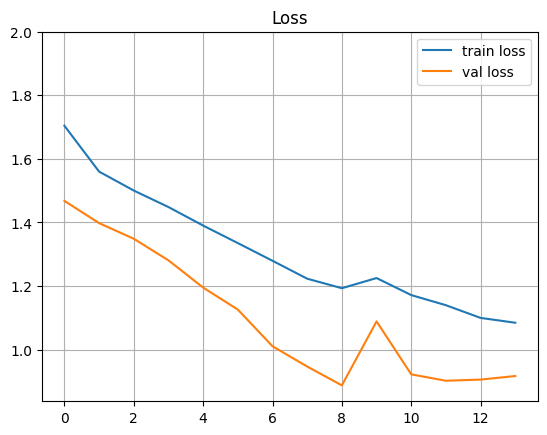

<Figure size 640x480 with 0 Axes>

In [34]:
### Evaluation LSTM
plot_loss(history_sel_LSTM.history,maxy=2.0)

### Save and Verify Model
Save in `model`
Verify model by showing train_pred

In [35]:
model_sel_LSTM_b = load_model(MODEL_DIR+'/model_sel_LSTM.keras')
pred_sel_LSTM = model_sel_LSTM.predict(X_model_sel)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


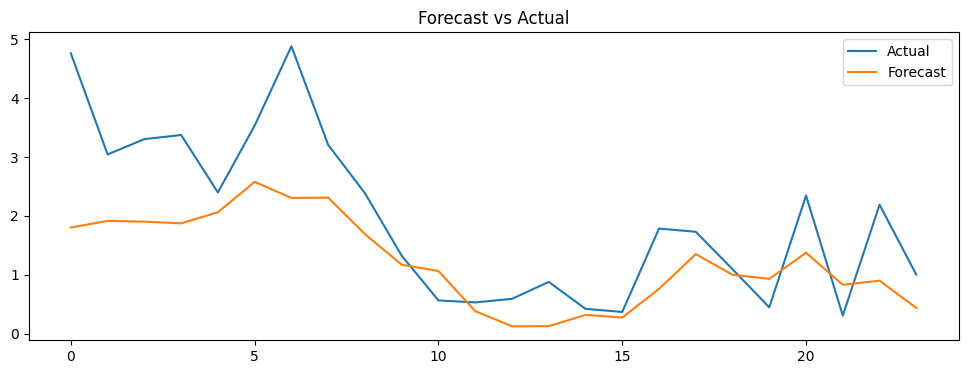

In [36]:
plot_forecast(y_model_sel[0], pred_sel_LSTM[0])


### S2S
- Design a Sequence to Sequence model with such layers:
    - Encoder:
        - An Input specifier to ensure encoder shape (None, 168, 8)
        - A LSTM layer with 32 Gated Memory Cells, with L2 Regularization: 0.01
        - A Dropout layer to drop 20% of parameters
        - A LSTM layer with 32 Gated Memory Cells, with L2 Regularization: 0.01
    - Decoder: 
        - An Input specifier to ensure encoder shape (None, 24, 7)
        - A LSTM layer with 32 Gated Memory Cells, with L2 Regularization: 0.01
        - A Dropout layer to drop 20% of parameters
        - A LSTM layer with 32 Gated Memory Cells, with L2 Regularization: 0.01
        - A Dropout layer to drop 20% of parameters
        - A Dense layer with 24 units for linear output, with L2 Regularization: 0.01
    - IO: The hidden state and cell memory from encoder LSTM is passed to decoder LSTM as initial state. 

- Compile with such hyperparameters:
    - Adam optimizer
    - learning rate: 1e-3
    - loss: mse
    - metrics: mae

- Train with such hyperparameters:
    - validation split: 0.2
    - batch size: 32
    - maxmum epochs: 100
    - no shuffle
    - early stop monitor: validation loss
    - early stop patience: 5
    - check point metric: validation loss 

In [219]:
#  Build S2S Model

def build_S2S(encoder_input, decoder_input, units=64, dropout = 0.2, lr = 1e-3, l2=0.001):
    #Encoder
    encoder_input = layers.Input(shape=encoder_input.shape[1:], name='EncoderInput')
    encoder_lstm1 = layers.LSTM(units, return_state=True, name='Encoder1', kernel_regularizer=regularizers.L2(l2))
    # encoder_dropout = layers.Dropout(rate=dropout)
    # encoder_lstm2 = layers.LSTM(units, return_state=True, name='Encoder2', kernel_regularizer=regularizers.L2(l2))

    #Decoder
    decoder_input = layers.Input(shape=decoder_input.shape[1:], name='DecoderInput')
    decoder_lstm1 = layers.LSTM(units, return_sequences=True, name='Decoder1', kernel_regularizer=regularizers.L2(l2))
    # decoder_dropout1 = layers.Dropout(rate=dropout)
    # decoder_lstm2 = layers.LSTM(units, return_sequences=True, name='Decoder2', kernel_regularizer=regularizers.L2(l2))
    decoder_dropout2 = layers.Dropout(rate=dropout)
    decoder_dense = layers.Dense(1, name='DecoderDense', kernel_regularizer=regularizers.L2(l2))

    #IO
    _, state_h, state_c  = encoder_lstm1(encoder_input)
    # encoder_output2 = encoder_lstm1(encoder_output1)
    # _, state_h, state_c = encoder_lstm2(encoder_output2)

    decoder_output1 = decoder_lstm1(decoder_input, initial_state=[state_h, state_c])
    # decoder_output2 = decoder_dropout1(decoder_output1)
    # decoder_output3 = decoder_lstm2(decoder_output2)
    decoder_output4 = decoder_dropout2(decoder_output1)
    final_output = decoder_dense(decoder_output4)

    #Model
    model = Model(inputs=[encoder_input, decoder_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

In [220]:
delete_model('model_sel_S2S', 'history_sel_S2S')

model_sel_S2S = build_S2S(X_model_sel, di_model_sel)
model_sel_S2S.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput        │ (None, 168, 8)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderInput        │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder1 (LSTM)     │ [(None, 64),      │     18,688 │ EncoderInput[0][… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder1 (LSTM)     │ (None, 24, 64)    │     18,432 │ DecoderInput[0][… │
│                     │                   │            │ Encoder1[0][1],   │
│                     │                   │            │ Encoder1[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ Decoder1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderDense        │ (None, 24, 1)     │         65 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,185 (145.25 KB)

 Trainable params: 37,185 (145.25 KB)

 Non-trainable params: 0 (0.00 B)

In [221]:
# Train S2S Model

history_sel_S2S = model_sel_S2S.fit(
    [X_model_sel, di_model_sel],  
    y_model_sel,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks = [early_stop(5), check_point('model_sel_S2S')],
    shuffle=False
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.7062 - mae: 1.0703 - val_loss: 1.3669 - val_mae: 0.9815
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.5282 - mae: 0.9935 - val_loss: 1.3017 - val_mae: 0.9575
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5095 - mae: 0.9844 - val_loss: 1.2723 - val_mae: 0.9442
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.4872 - mae: 0.9749 - val_loss: 1.2383 - val_mae: 0.9276
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.4779 - mae: 0.9700 - val_loss: 1.2042 - val_mae: 0.9116
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4667 - mae: 0.9647 - val_loss: 1.1773 - val_mae: 0.8981
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.4542 - mae: 0.9598 - val_loss: 1.1588 - val_mae: 0.8871
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.4471 - mae: 0.9551 - val_loss: 1.1434 - val_mae: 0.8764
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - lo

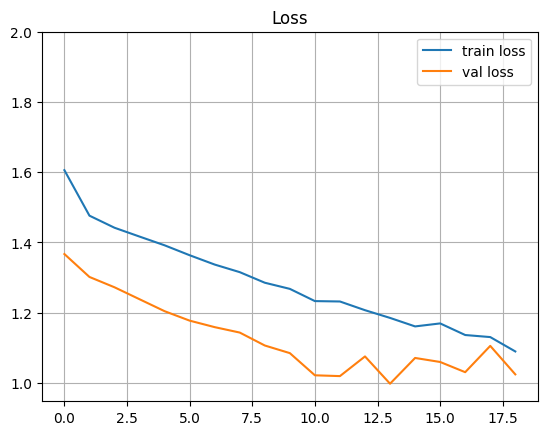

<Figure size 640x480 with 0 Axes>

In [222]:
# Evaluate S2S Model
plot_loss(history_sel_S2S.history, maxy=2.0)

### Save and Verify Model
Save in `model`
Verify model by showing train_pred

In [223]:
model_sel_S2S_b = load_model(MODEL_DIR + '/model_sel_S2S.keras')

In [224]:

pred_sel_S2S = model_sel_S2S_b.predict([X_model_sel, di_model_sel])

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


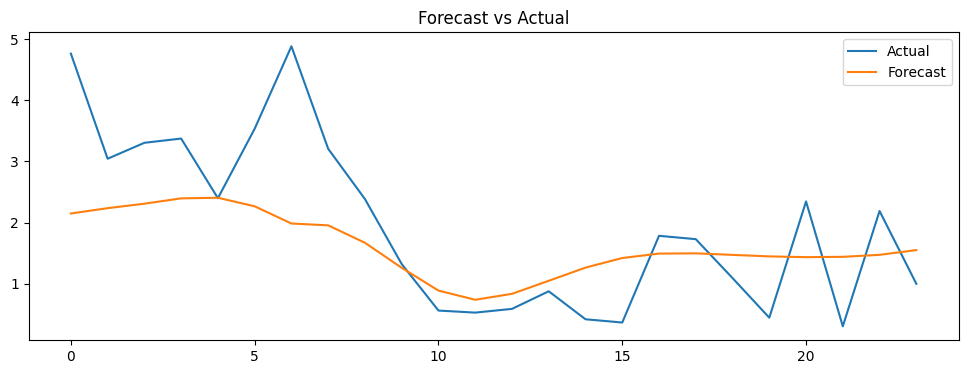

In [226]:
plot_forecast(y_model_sel[0], pred_sel_S2S[0])

## 3. Hyperparameter Tuning
The model selected is S2S for significantly better performance. 


In [227]:
### Hyperparameter Tuning
# delete hyperparameter tuning logs
%rm -rf ./hparam/*


In [45]:

%tensorboard --logdir hparam/log

### Hyperparameters
Hyperparameters to be tuned:
- Round 1
    - `dropout`: `[0.3, 0.4, 0.5]`
    - `batch_size`: `[16， 32]`
    - `l2`: `[0.001, 0.01]`
- Round 2
    - `learning_rate`: `[5e-5, 1e-4, 2e-4, 3e-4, 5e-4]`
    - `units`: `[8, 16, 32]`


In [228]:
# Tuning hyperparameters 

# Round 1
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.3, 0.4, 0.5]))
HP_UNITS = hp.HParam('units', hp.Discrete([16, 32]))
HP_L2 = hp.HParam('l2', hp.Discrete([1e-3, 1e-2]))

#Round 2
HP_LR = hp.HParam('learning_rate', hp.Discrete([5e-5, 1e-4, 5e-4, 1e-3]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([16, 32]))

#Metrics
METRIC_LOSS = 'loss'
METRIC_GAP = 'gap'


In [229]:
def train_test_model(hparams, log_dir, round, id):
    model = build_S2S(
        X_tune,
        di_tune, 
        units=hparams[HP_UNITS], 
        dropout=hparams[HP_DROPOUT], 
        lr=hparams[HP_LR],
        l2=hparams[HP_L2],
    )
    history = model.fit(
        [X_tune, di_tune], 
        y_tune, 
        validation_split=0.2, 
        epochs=100, 
        batch_size=hparams[HP_BATCH_SIZE], 
        verbose=0, 
        callbacks=[
            check_point(f'round{round}/hparam_S2S_{id}', hparam=True),
            early_stop(5),
            TensorBoard(log_dir),
            hp.KerasCallback(log_dir, hparams)
        ]
    )
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    best_epoch = np.argmin(val_loss_history)
    min_train_loss = train_loss_history[best_epoch]
    min_val_loss = val_loss_history[best_epoch]

    loss_gap = abs(min_train_loss - min_val_loss)
    with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.scalar(METRIC_LOSS, min_val_loss, step=1)
        tf.summary.scalar(METRIC_GAP, loss_gap, step=1)

    # delete the model to free up VRAM
    delete_model('model', 'history')
    return train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap

### Train Round 1
Tune hyperparameters on `hparam_tuning` subset with `validation_split = 0.2`. 

When tuning, reduce EarlyStop patience to 5, limit 100 epochs. 

- Save models in `model/tune`
 -Save logs in `log/hparam`

In [230]:
# initiate tfboard log
with tf.summary.create_file_writer('hparam/log/round1').as_default():
    hp.hparams_config(
        hparams=[HP_LR, HP_BATCH_SIZE, HP_DROPOUT, HP_UNITS, HP_L2],
        metrics=[
            hp.Metric(METRIC_LOSS, display_name='MSE'), 
            hp.Metric(METRIC_GAP, display_name='Loss Gap')
        ],
    )


In [231]:
def run_hparam(session_num, hparams, round):
    run_name = f"run-{session_num}"
    print(f"--- Starting trial: {run_name}")
    print({h.name: hparams[h] for h in hparams})
    log_dir = f'hparam/log/round{round}/{run_name}'
    train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap = train_test_model(hparams, log_dir, round, session_num)
    print(f'best loss {min_train_loss, min_val_loss} found at epoch {best_epoch}, with gap {loss_gap}')

    return train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap


In [232]:

session_num1 = 0
results1 = []

for dropout in HP_DROPOUT.domain.values:
    for units in HP_UNITS.domain.values:
        for l2 in HP_L2.domain.values:
            hparams1 = {
                HP_LR: 1e-4,
                HP_BATCH_SIZE: 32,
                HP_DROPOUT: dropout,
                HP_UNITS: units,
                HP_L2: l2,
            }
            train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap = run_hparam(session_num1, hparams1, round=1)
            results1.append((hparams1, train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap))
            session_num1 += 1


--- Starting trial: run-0
{'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.3, 'units': 16, 'l2': 0.001}
best loss (0.8695352673530579, 0.6350401639938354) found at epoch 23, with gap 0.2344951033592224
--- Starting trial: run-1
{'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.3, 'units': 16, 'l2': 0.01}
best loss (0.7482579350471497, 0.6062527894973755) found at epoch 72, with gap 0.14200514554977417
--- Starting trial: run-2
{'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.3, 'units': 32, 'l2': 0.001}
best loss (0.9172704815864563, 0.7102352976799011) found at epoch 6, with gap 0.20703518390655518
--- Starting trial: run-3
{'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.3, 'units': 32, 'l2': 0.01}
best loss (0.9987199902534485, 0.775225043296814) found at epoch 13, with gap 0.22349494695663452
--- Starting trial: run-4
{'learning_rate': 0.0001, 'batch_size': 32, 'dropout': 0.4, 'units': 16, 'l2': 0.001}
best loss (0.7012069225311279, 0.534654438495636)

### Capture Round 1
Use tensorboard and dataframe to display tune result

In [233]:
df1, train_loss_tune1, val_loss_tune1 = catch_hparam_result(results1)
df1[:10]

,learning_rate,batch_size,dropout,units,l2,best_epoch,min_train_loss,min_val_loss,loss_gap
4,0.0001,32,0.4,16,0.001,59,0.701207,0.534654,0.166552
10,0.0001,32,0.5,32,0.001,27,0.736026,0.577633,0.158393
1,0.0001,32,0.3,16,0.010,72,0.748258,0.606253,0.142005
6,0.0001,32,0.4,32,0.001,7,0.922192,0.630163,0.292029
0,0.0001,32,0.3,16,0.001,23,0.869535,0.635040,0.234495
8,0.0001,32,0.5,16,0.001,25,0.897972,0.642752,0.255220
7,0.0001,32,0.4,32,0.010,43,0.762404,0.649699,0.112705
2,0.0001,32,0.3,32,0.001,6,0.917270,0.710235,0.207035
9,0.0001,32,0.5,16,0.010,31,0.963687,0.721732,0.241955
11,0.0001,32,0.5,32,0.010,22,0.911498,0.731936,0.179561


### Find Best Round 1

Find best hparams tuned with metrics and observed criterias

In [248]:
df_filtered1 = df1[df1['best_epoch'] > 20]
df_filtered11 = df_filtered1[df_filtered1['loss_gap'] < 0.15]
best_param1 = df_filtered11.loc[df_filtered11['min_val_loss'].idxmin()]
best_param1

learning_rate      0.000100
batch_size        32.000000
dropout            0.300000
units             16.000000
l2                 0.010000
best_epoch        72.000000
min_train_loss     0.748258
min_val_loss       0.606253
loss_gap           0.142005
Name: 1, dtype: float64

In [249]:
# save best hyperparameters

BEST_DROPOUT = best_param1['dropout']
BEST_UNITS = int(best_param1['units'])
BEST_L2 = best_param1['l2']
BEST_NAME1 = best_param1.name
# use tuned best hyperparameters if didn't run tuning

# BEST_DROPOUT = 0.4
# BEST_UNITS = 32
# BEST_L2 = 0.01
# BEST_NAME1 = 11

### Verify Loss

In [250]:
best_history1 = pd.DataFrame({
        'loss': train_loss_tune1[BEST_NAME1],
        'val_loss': val_loss_tune1[BEST_NAME1]
    })

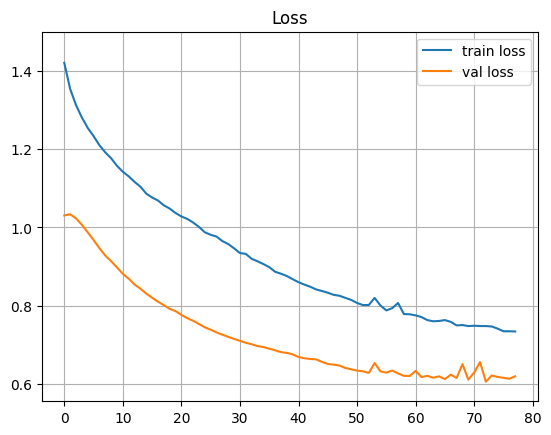

<Figure size 640x480 with 0 Axes>

In [251]:
plot_loss(best_history1, maxy=1.5)

### Train Round 2
Tune hyperparameters on `hparam_tuning` subset with `validation_split = 0.2`. 

When tuning, reduce EarlyStop patience to 5, limit 100 epochs. 

- Save models in `model/tune`
 -Save logs in `log/hparam`

In [252]:
%rm -rf ./hparam/log/round2/*

In [253]:
# initiate tfboard log
with tf.summary.create_file_writer('hparam/log/round2').as_default():
    hp.hparams_config(
        hparams=[HP_LR, HP_BATCH_SIZE, HP_DROPOUT, HP_UNITS, HP_L2],
        metrics=[
            hp.Metric(METRIC_LOSS, display_name='MSE'), 
            hp.Metric(METRIC_GAP, display_name='Loss Gap')
        ],
    )


In [254]:
session_num2 = 0
results2 = []
# iterate among all hyperparameters to be tuned
for lr in HP_LR.domain.values:
    for batch in HP_BATCH_SIZE.domain.values:
        hparams2 = {
        HP_LR: lr,
        HP_BATCH_SIZE: batch,
        HP_DROPOUT: BEST_DROPOUT,
        HP_UNITS: BEST_UNITS,
        HP_L2: BEST_L2,
    }
        train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap = run_hparam(session_num2, hparams2, round=2)
        results2.append((hparams2, train_loss_history, val_loss_history, best_epoch, min_train_loss, min_val_loss, loss_gap))
        session_num2 += 1


--- Starting trial: run-0
{'learning_rate': 5e-05, 'batch_size': 16, 'dropout': np.float64(0.3), 'units': 16, 'l2': np.float64(0.01)}
best loss (0.8535205721855164, 0.7348578572273254) found at epoch 41, with gap 0.11866271495819092
--- Starting trial: run-1
{'learning_rate': 5e-05, 'batch_size': 32, 'dropout': np.float64(0.3), 'units': 16, 'l2': np.float64(0.01)}
best loss (0.8809950947761536, 0.7264400720596313) found at epoch 65, with gap 0.15455502271652222
--- Starting trial: run-2
{'learning_rate': 0.0001, 'batch_size': 16, 'dropout': np.float64(0.3), 'units': 16, 'l2': np.float64(0.01)}
best loss (0.8624184131622314, 0.7331793308258057) found at epoch 21, with gap 0.12923908233642578
--- Starting trial: run-3
{'learning_rate': 0.0001, 'batch_size': 32, 'dropout': np.float64(0.3), 'units': 16, 'l2': np.float64(0.01)}
best loss (0.7765368223190308, 0.6245331764221191) found at epoch 51, with gap 0.15200364589691162
--- Starting trial: run-4
{'learning_rate': 0.0005, 'batch_size': 

### Capture Round 2
Use tensorboard and dataframe to display tune result

In [255]:
# display hyperparameter tuning result
df2, train_loss_tune2, val_loss_tune2 = catch_hparam_result(results2)
df2[:10]

,learning_rate,batch_size,dropout,units,l2,best_epoch,min_train_loss,min_val_loss,loss_gap
6,0.00100,16,0.3,16,0.01,8,0.672878,0.541651,0.131227
5,0.00050,32,0.3,16,0.01,19,0.678899,0.588104,0.090796
4,0.00050,16,0.3,16,0.01,10,0.722843,0.601708,0.121135
3,0.00010,32,0.3,16,0.01,51,0.776537,0.624533,0.152004
7,0.00100,32,0.3,16,0.01,9,0.718520,0.671549,0.046971
1,0.00005,32,0.3,16,0.01,65,0.880995,0.726440,0.154555
2,0.00010,16,0.3,16,0.01,21,0.862418,0.733179,0.129239
0,0.00005,16,0.3,16,0.01,41,0.853521,0.734858,0.118663


### Find Best Round 2

Find best hparams tuned with metrics and observed criterias

In [256]:
df_filtered2 = df2[df2['best_epoch'] > 15]
best_param2 = df_filtered2.loc[df_filtered2['min_val_loss'].idxmin()]
best_param2

learning_rate      0.000500
batch_size        32.000000
dropout            0.300000
units             16.000000
l2                 0.010000
best_epoch        19.000000
min_train_loss     0.678899
min_val_loss       0.588104
loss_gap           0.090796
Name: 5, dtype: float64

In [257]:
# save best hyperparameters

BEST_LR = best_param2['learning_rate']
BEST_BATCH_SIZE = int(best_param2['batch_size'])
BEST_NAME2 = best_param2.name
# use tuned best hyperparameters if didn't run tuning

# BEST_LR = 3e-4
# BEST_BATCH_SIZE = 16
# BEST_NAME2 = 6

### Verify Loss

In [258]:
best_history2 = pd.DataFrame({
        'loss': train_loss_tune2[BEST_NAME2],
        'val_loss': val_loss_tune2[BEST_NAME2]
    })

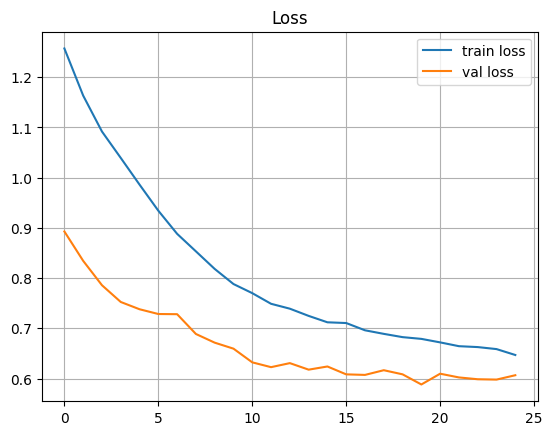

<Figure size 640x480 with 0 Axes>

In [259]:
plot_loss(best_history2)

### Save and Load Tuned Model
Evaluate with tune_pred

In [260]:
best_model = load_model(f'hparam/model/round2/hparam_S2S_{BEST_NAME2}.keras')
best_y_pred = best_model.predict([X_tune, di_tune])
best_model.evaluate([X_tune, di_tune], y_tune)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7670 - mae: 0.6346


[0.6340605020523071, 0.5702785849571228]

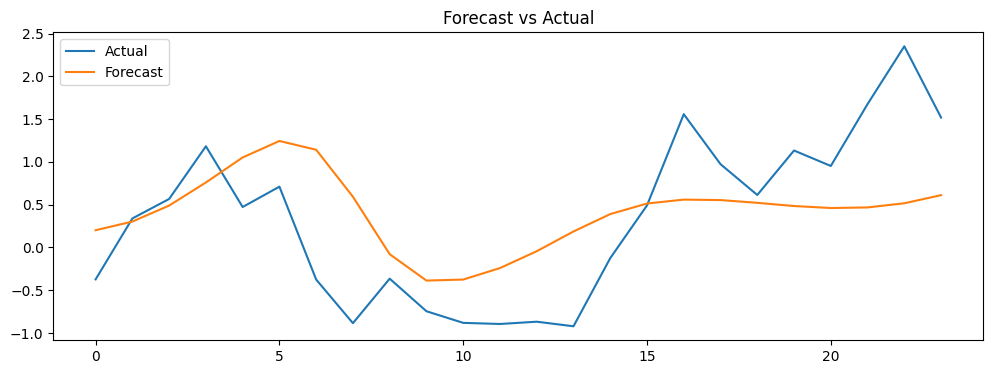

In [261]:
plot_forecast(y_tune[0], best_y_pred[0])

## 4. Model Train and Evaluation


### Train Tuned Model
Train the tuned model on `train` subset with `validation_split = 0.2`. 

Save model in `model`. 

In [262]:
### Train Tuned Model
delete_model('final_model', 'final_history')
final_model = build_S2S(X_train, di_train, units = BEST_UNITS, dropout=BEST_DROPOUT, lr=BEST_LR, l2=BEST_L2)
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput        │ (None, 168, 8)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderInput        │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder1 (LSTM)     │ [(None, 16),      │      1,600 │ EncoderInput[0][… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder1 (LSTM)     │ (None, 24, 16)    │      1,536 │ DecoderInput[0][… │
│                     │                   │            │ Encoder1[0][1],   │
│                     │                   │            │ Encoder1[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 16)    │          0 │ Decoder1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderDense        │ (None, 24, 1)     │         17 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,153 (12.32 KB)

 Trainable params: 3,153 (12.32 KB)

 Non-trainable params: 0 (0.00 B)

In [263]:
final_history = final_model.fit(
    [X_train, di_train], 
    y_train, 
    validation_split=0.2, 
    epochs=200, 
    batch_size=BEST_BATCH_SIZE*4, 
    callbacks=[
        check_point(f'final_S2S'),
        early_stop(5),
    ]
)

Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.4628 - mae: 0.8430 - val_loss: 0.9657 - val_mae: 0.6949
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.1300 - mae: 0.7612 - val_loss: 0.8644 - val_mae: 0.6783
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.0079 - mae: 0.7273 - val_loss: 0.7995 - val_mae: 0.6616
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.9288 - mae: 0.7044 - val_loss: 0.7522 - val_mae: 0.6416
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.8809 - mae: 0.6839 - val_loss: 0.7004 - val_mae: 0.6065
Epoch 6/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.8171 - mae: 0.6538 - val_loss: 0.6588 - val_mae: 0.5831
Epoch 7/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7783 - mae: 0.6341 - val_loss: 0.6346 - val_mae: 0.5744
Epoch 8/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7572 - mae: 0.6268 - val_loss: 0.6185 - val_mae: 0.5587
Epoch 9/200
109/109 ━━━━━━━━━━━━━━━━━━━━

### Verify Loss

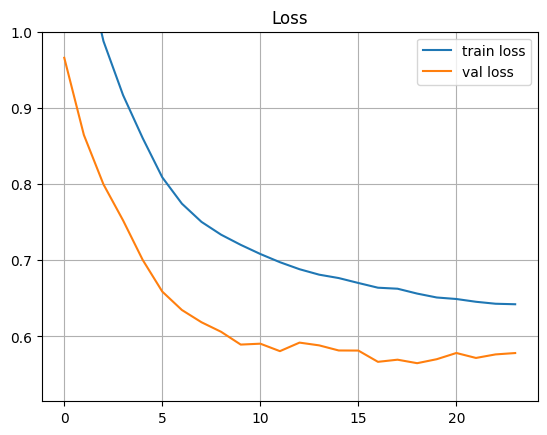

<Figure size 640x480 with 0 Axes>

In [264]:
plot_loss(final_history.history, maxy=1.0)

In [265]:
final_model = load_model('model/final_S2S.keras')

### Evaluate Model
Use `test` subset to evaluate model with metrics $\mathrm{MSE}$ and $\mathrm{MAE}$. 

Show prediction on train_pred, and test_pred

In [266]:
### Evaluate Model
final_model.evaluate([X_test, di_test], y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2962 - mae: 0.3992


[0.31212666630744934, 0.40308839082717896]

In [267]:
train_pred = final_model.predict([X_train, di_train])

542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


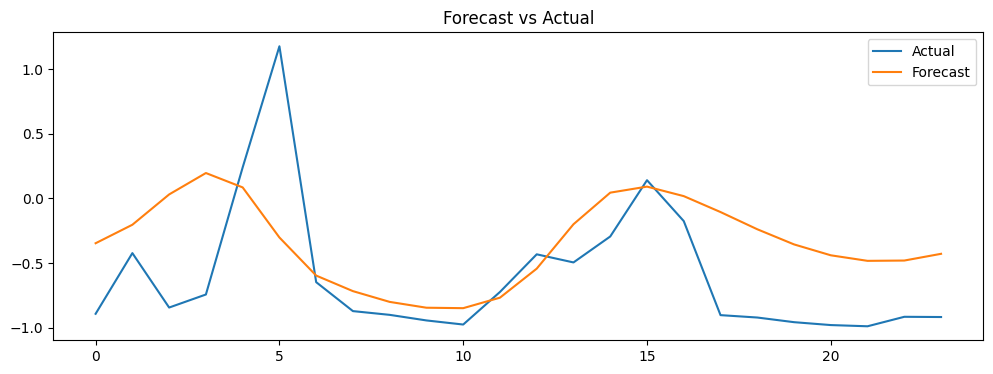

In [268]:
plot_forecast(y_train[0], train_pred[1])

In [269]:
final_pred = final_model.predict([X_test, di_test])

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


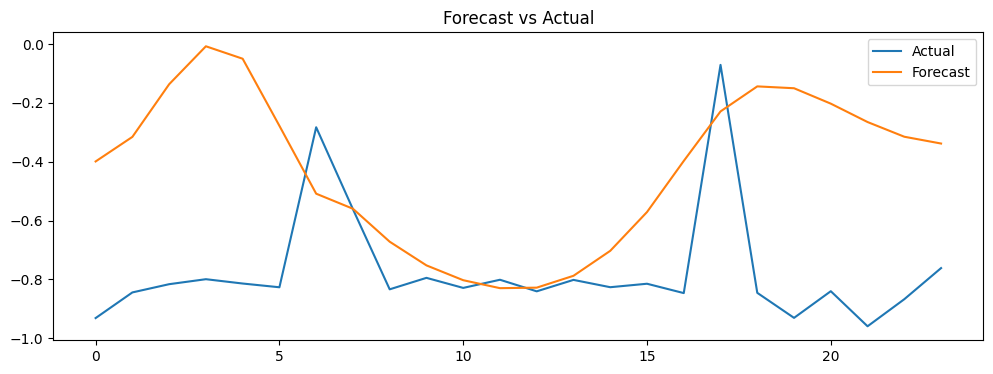

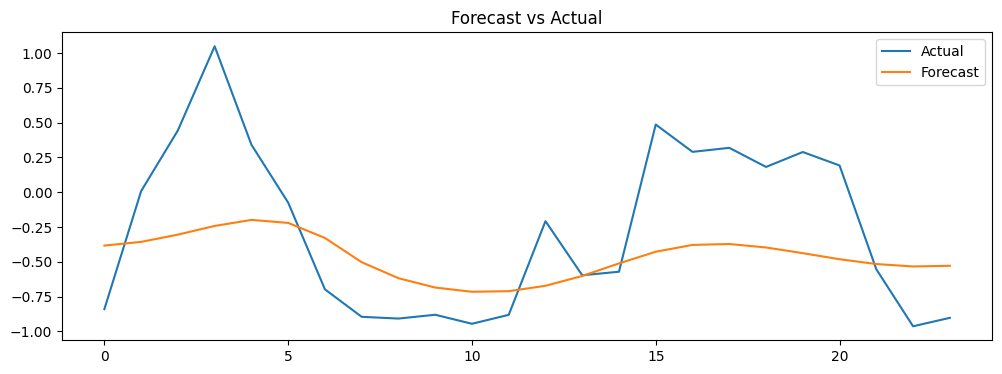

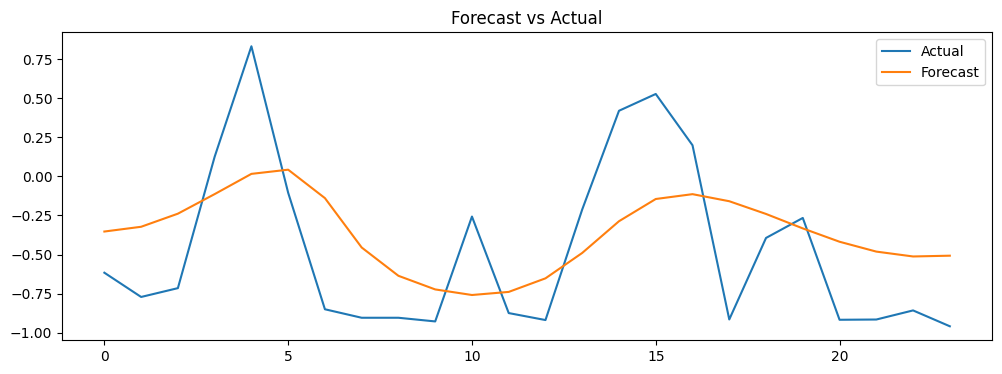

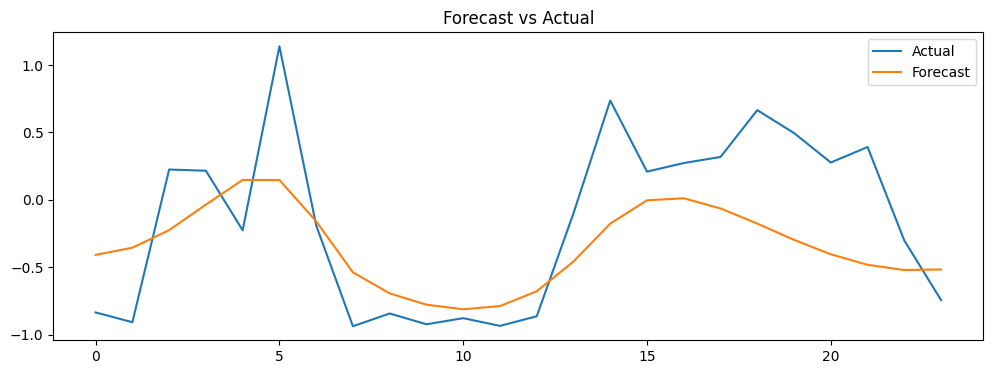

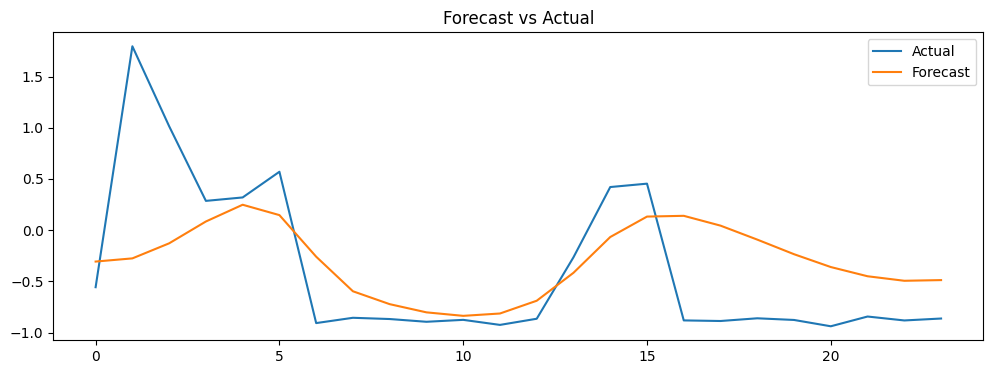

In [270]:
for i in range(5):
    plot_forecast(y_test[i*24], final_pred[i*24])

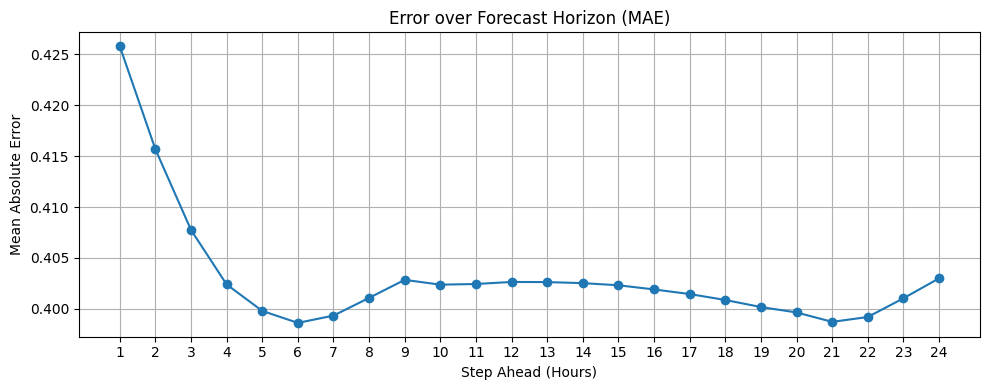

In [271]:
plot_forecast_error(y_test, final_pred)

### Analyze Model Performance


## 5. Forecaste to Energy Optimization

### Prepare forecast data

`test1` and `test2` subset, take one week ahead timestamp predict the `global_active_power` of the subset. 



In [272]:
start_time_1 = df_hourly_reco.iloc[27000].name
start_time_2 = df_hourly_reco.iloc[27000+2160+2160].name

In [273]:
def multi_round_forecast(model, encoder_input, decoder_input, y_true, rounds, forecast_horizon=24):
    """
    initial_input: shape (1, lag, features)
    rounds: total number of days to predict
    forecast_horizon: number of hours predicted per model call
    """
    predictions = []
    targets = []

    ei = np.zeros((1, 168, 8), dtype=np.float32)
    di = np.zeros((1, 24, 7), dtype=np.float32)

    for r in range(rounds):

        ei[0] = encoder_input[r*forecast_horizon]
        di[0] = decoder_input[r*forecast_horizon]

        y_pred = model.predict([ei, di], verbose=0)
        predictions.append(y_pred.squeeze())
        targets.append(y_true[r*forecast_horizon].squeeze())
        di[0, 1:, 0] = y_pred[0, :-1, 0]

    y_preds = np.concatenate(predictions)
    y_targets = np.concatenate(targets)
    mae = mean_absolute_error(y_targets, y_preds)
    return y_preds, mae

In [277]:
forecast1, mae1 = multi_round_forecast(final_model, X_test1, di_test1, y_test1, 1)
forecast2, mae2 = multi_round_forecast(final_model, X_test2, di_test2, y_test2, 7)



### Visualize Result
Predicted vs Actual

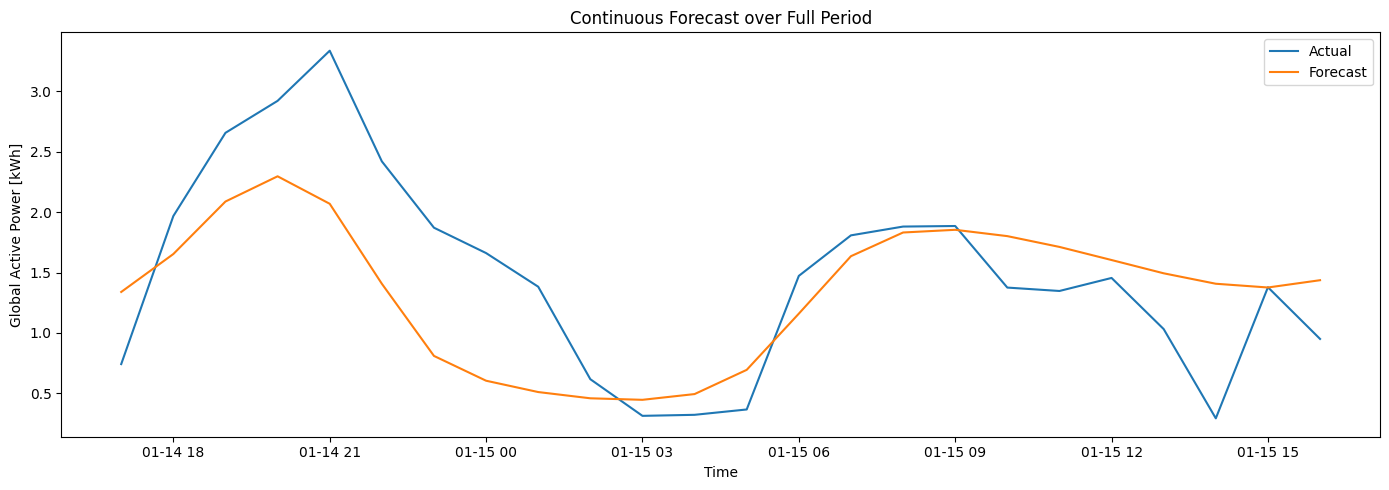

In [278]:
plot_multi_forecast(y_test1, forecast1, scaler, start_time_1)

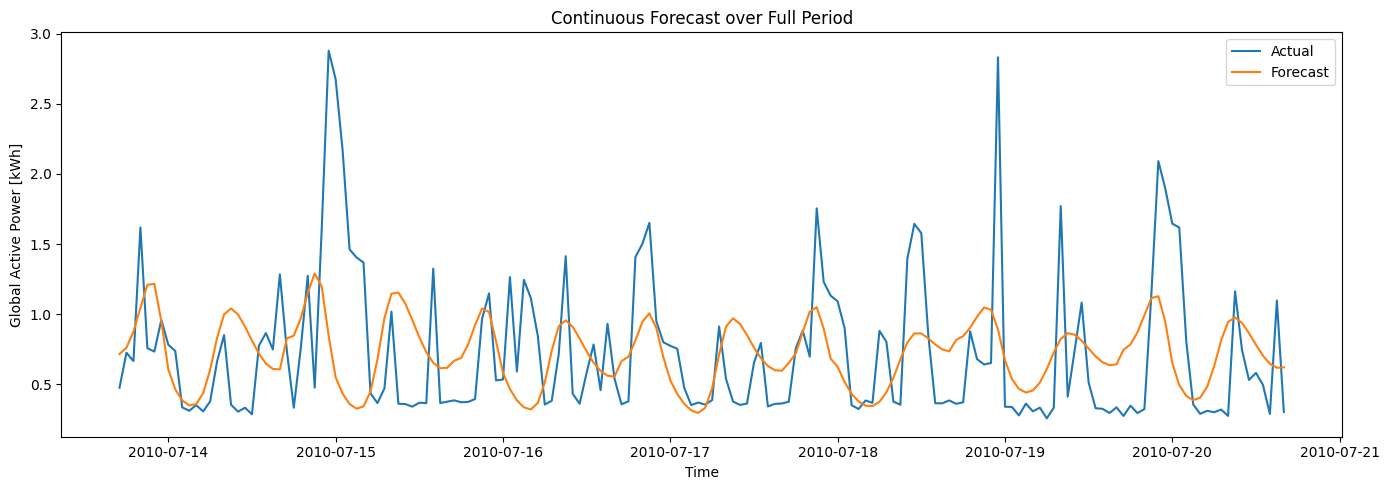

In [279]:
plot_multi_forecast(y_test2, forecast2, scaler, start_time_2)

### Merics
MSE, MAE

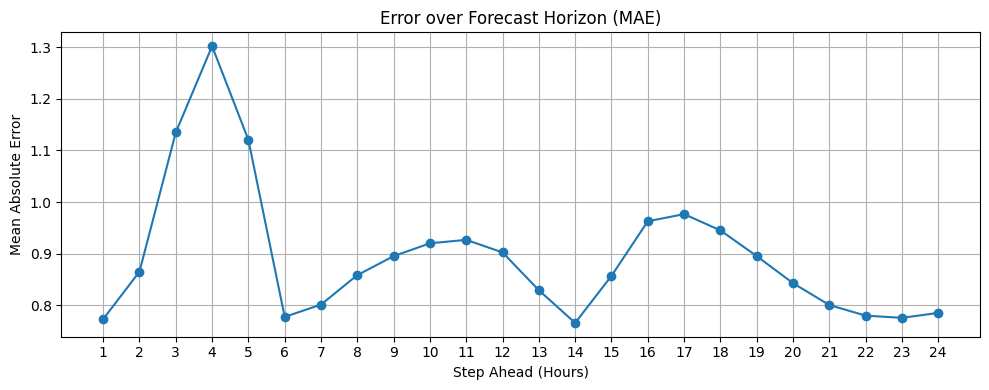

In [280]:
plot_forecast_error(y_test1, forecast1)

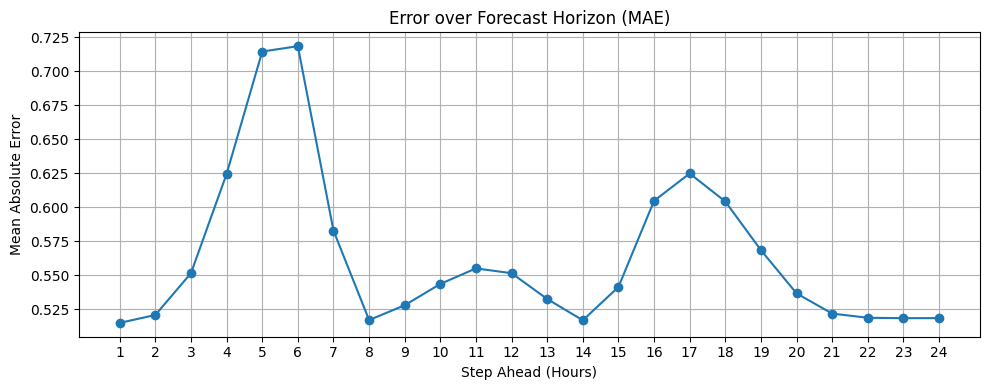

In [281]:
plot_forecast_error(y_test2, forecast2[:24])